In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib

Load the sales dataset

In [80]:
sales_data = pd.read_csv('/content/drive/My Drive/sales-project/stores_sales.csv')

Checking the size of data

In [44]:
sales_data.shape

(6435, 8)

Taking a quick look at the data

In [45]:
sales_data.head()

,store,date,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106



How many stores are there in the data?




In [46]:
sales_data['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

Checking for missing values

In [47]:
sales_data.isnull().sum()

store           0
date            0
weekly_sales    0
holiday_flag    0
temperature     0
fuel_Price      0
cpi             0
unemployment    0
dtype: int64

Checking for duplicates

In [48]:
print("Number of Duplicates" ,len(sales_data[sales_data.duplicated()]))

Number of Duplicates 0


Checking for data types

In [49]:
#sales_data.info()
sales_data.dtypes

store             int64
date             object
weekly_sales    float64
holiday_flag      int64
temperature     float64
fuel_Price      float64
cpi             float64
unemployment    float64
dtype: object

Convert the **date** feature to a datetime data type

In [82]:
sales_data['date'] = pd.to_datetime(sales_data['date'])

<ipython-input-82-b98876987cc0>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales_data['date'] = pd.to_datetime(sales_data['date'])


In [19]:
sales_data.dtypes

store                    int64
date            datetime64[ns]
weekly_sales           float64
holiday_flag             int64
temperature            float64
fuel_Price             float64
cpi                    float64
unemployment           float64
dtype: object

Creating time series features from the **date** feature

In [83]:
sales_data['year'] = sales_data['date'].dt.year
sales_data['month'] = sales_data['date'].dt.month
sales_data['day'] = sales_data['date'].dt.day
sales_data['day_of_week'] = sales_data['date'].dt.dayofweek  # Monday=0, Sunday=6
sales_data['day_of_year'] = sales_data['date'].dt.dayofyear
sales_data['week_of_year'] = sales_data['date'].dt.isocalendar().week

In [84]:
sales_data.columns

Index(['store', 'date', 'weekly_sales', 'holiday_flag', 'temperature',
       'fuel_Price', 'cpi', 'unemployment', 'year', 'month', 'day',
       'day_of_week', 'day_of_year', 'week_of_year'],
      dtype='object')

Dropping the **date** feature

In [85]:
sales_data.drop('date',axis = 1, inplace = True)

Basic statistics

In [57]:
sales_data.describe()

,store,weekly_sales,holiday_flag,temperature,fuel_Price,cpi,unemployment,year,month,day,day_of_week,day_of_year,week_of_year
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.0
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,2010.965035,6.475524,15.650350,3.573427,181.608392,26.0
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,0.797019,3.321797,8.753908,1.426581,101.514857,14.511794
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,2010.000000,1.000000,1.000000,0.000000,4.000000,1.0
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,2010.000000,4.000000,8.000000,4.000000,96.000000,14.0
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,2011.000000,6.000000,16.000000,4.000000,181.000000,26.0
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,2012.000000,9.000000,23.000000,4.000000,267.000000,38.0
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,2012.000000,12.000000,31.000000,6.000000,365.000000,52.0


Analyzing feature importance using RandomForest weights to understand which features are most influential in predicting weekly sales

<BarContainer object of 12 artists>

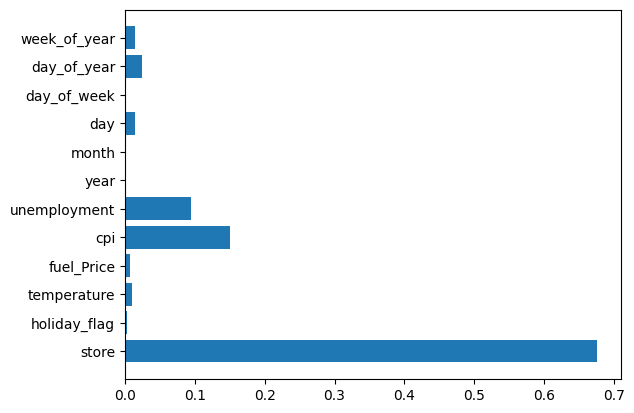

In [86]:
#Converting the data type of the week feature from UInt32 to int
sales_data['week_of_year'] = sales_data['week_of_year'].astype(int)
#input data
features = sales_data.drop('weekly_sales',axis = 1)
#output data
target = sales_data['weekly_sales']
rf = RandomForestRegressor(n_estimators=100)
rf.fit(features,target)
plt.barh(features.columns, rf.feature_importances_)

Dropping irrelevant features

In [87]:
sales_data.drop(['day_of_week','month','year','holiday_flag','temperature', 'fuel_Price'], axis = 1, inplace = True)


Checking for features redundancy using Pearson Correlation



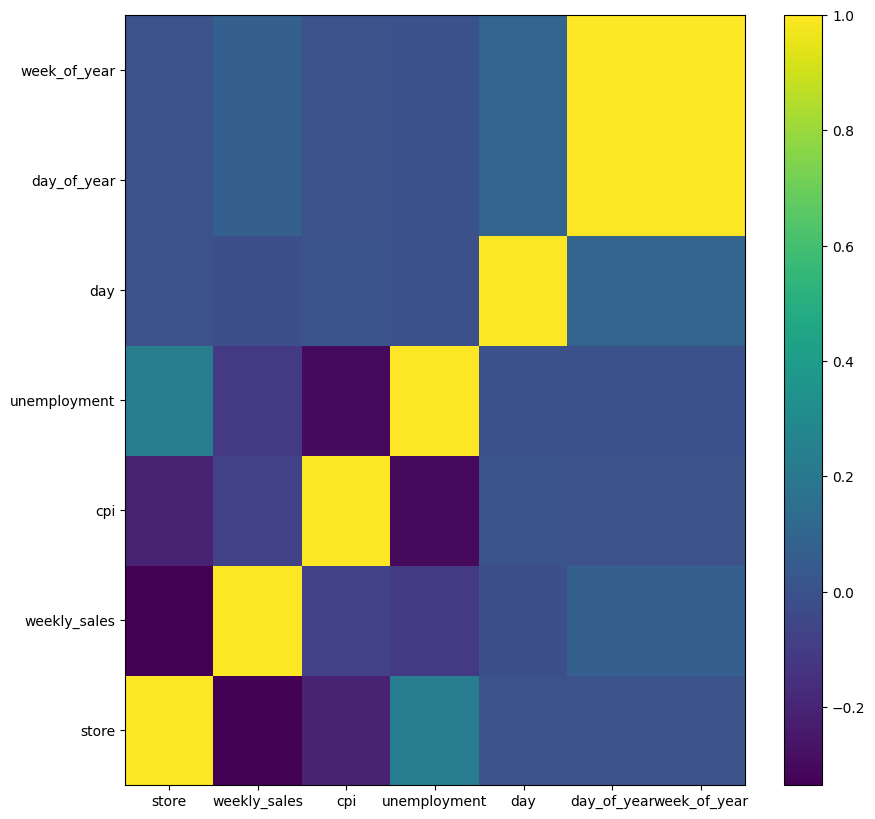

In [88]:
plt.figure(figsize=(10, 10))
corr = sales_data.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)
plt.colorbar(c)

Seems that there is a slight correlation between cpi and unemployment, and between unemployment and store features

In [89]:
#Dropping unemployment and cpi features
sales_data.drop(['cpi', 'unemployment'], axis = 1, inplace = True)

Model training

In [90]:
#Preparing train and test data
X = sales_data.drop('weekly_sales',axis = 1)
y = sales_data['weekly_sales']
x_train, x_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state=0)

Hyperparameter tuning to select the best performing model

In [91]:
param_grid = {'n_estimators': np.arange(20, 150),
              'max_depth': np.arange(4, 15)}

grid = GridSearchCV(XGBRegressor(), param_grid, cv=5)

grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])})

In [93]:
print(grid.best_score_)
print(grid.best_params_)

0.9719762921027545
{'max_depth': 7, 'n_estimators': 84}


In [95]:
model = grid.best_estimator_

Evaluating the model

In [96]:
y_pred = model.predict(x_test)
print("R2 score  :",r2_score(y_test, y_pred))
print("MSE score  :",mean_squared_error(y_test, y_pred))
print("RMSE: ",sqrt(mean_squared_error(y_test, y_pred)))

R2 score  : 0.9760706690416125
MSE score  : 7563162657.688951
RMSE:  86966.44558500106


In [97]:
model_filename = 'trained_model.joblib'
joblib.dump(model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to trained_model.joblib


In [98]:
loaded_model = joblib.load('trained_model.joblib')


In [118]:
test_sample = x_test.iloc[0:1]

In [119]:
predicted_sales = loaded_model.predict(test_sample)

In [120]:
predicted_sales

array([1188376.2], dtype=float32)

The model's performance can be improved by:

* increasing the amount of data to help it learn more patterns and generalize better
* using more advanced hyperparameter tuning techniques such as PSO or Bayesian Optimization
*  considering other hyperparameters such as min_child_weight and learning_rate
* using a wider range of values for hyperparameter tuning
*   creating additional features that might have an impact on sales, such as lagged sales (previous week's sales)

